In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_all_alphas, weather_all_costs, prediction_humidity, model_02, validate, dengue_weather

running model_02
getting cost from nweek ahead
getting bounded alphas with params for all params...
done getting alphas ...
prediction for humidity
dengue weather


In [37]:
def seperate_train_test(all_data, train_data, peak):
    peak_for_txt = peak -10
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,peak_for_txt,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,peak_for_txt,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

def plot_all_predictions(LAG, real, train, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real.cases,label='real')
    graph_title = "%s's Dengue Prediction with Weather Data"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    real_max = real.cases.max()
    train_max = train.cases.max()
    peak = max(real_max,train_max)
    seperate_train_test(real,train,peak)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,peak/2,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
#     plt.savefig("16-lags-16-weeks-9-temp-wks-chiangmai-00.png")
    
def show_predictions(params, real, train, province, ws):
    LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, AVGRH_WEEKS = params[0], params[1], params[2], params[3]
    
    predictions_to_plot = prediction_humidity.get_predictions(
        LAG, 
        TEMPERATURE_WEEKS,
        RAIN_WEEKS,
        AVGRH_WEEKS,
        real,
        ws,
        province)
    
    plot_all_predictions(LAG, 
                         real,
                         train,
                         province,
                         [1,2,4,8,16],
                         predictions_to_plot)


In [3]:
all_weather = pd.read_csv("weather01-16.csv")
all_weather.stn_name = all_weather.stn_name.apply(dengue_weather.remove_space)
all_dengue = pd.read_csv("all-dengues.csv")
all_dengue = all_dengue.rename(columns = {'จังหวัด' : 'province'})

In [61]:
                       # province_dengue: province_weather
# provinces_to_predict = {"Bangkok":"BangkokMetropolis",
#                         "PrachuapKhiriKhan":"PrachuapKhiriKhan",
#                         "PhraNakhonSiAyutthaya":"AyuttayaAgromet", 
#                         "Songkhla":"PhatthalungAgromet", 
#                         "Ratchaburi":"Ratchaburi", 
#                         "ChonBuri":"ChonBuri", 
#                         "NongKhai":"NongKhai",
#                         "SakonNakhon":"SakonNakhonAgromet",
#                         "ChiangMai":"ChiangMai",
#                         "ChiangRai":"ChiangRai"}

provinces_to_predict = {"Pathumthani":"PathumthaniAgromet",
                        "SamutPrakan":"PilotStation",
                        "NakhonPathom":"KamphaengSaenAgromet", 
                        "MahaSarakham":"KosumPhisai",  
                        "Pattani":"PattaniAirport", 
                        "SuratThani":"SuratThaniAgromet"}

province_data = {}
for province_for_dengue in provinces_to_predict:
    province_for_weather = provinces_to_predict.get(province_for_dengue)
    print province_for_dengue, province_for_weather
    
    province_data_to_predict = dengue_weather.get_dengue_weather_by_province(
                                                                    province_for_dengue, 
                                                                    province_for_weather, 
                                                                    all_dengue, 
                                                                    all_weather)
    province_data[province_for_dengue] = province_data_to_predict
    
# province data is dictionary of province to its train and real data, idx 0 and 1
# ex --> province_data.get('Bangkok')[0]

Pathumthani PathumthaniAgromet
SamutPrakan PilotStation
Pattani PattaniAirport
MahaSarakham KosumPhisai
NakhonPathom KamphaengSaenAgromet
SuratThani SuratThaniAgromet


In [63]:
# province_data

In [64]:
province_data_for_prediction = []
for province in province_data:
    province_train = province_data.get(province)[0]
    province_test = province_data.get(province)[1]
    province_data_for_prediction.append((province,province_train,province_test))
    

In [65]:
ws_csv = np.array(pd.read_csv("best-with-19-lags-9-temps-15-rains-1-humidity-ws-2nd-iter-model-a.csv").T)[0]

def province_prediction(data_for_prediction):
    
    province = data_for_prediction[0]
    train = data_for_prediction[1]
    real = data_for_prediction[2]
    
    print province
    print 
    print train.tail(1)
    print 
    print real.tail(1)
    
    LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, AVGRH_WEEKS = 19, 9, 15, 1
                                    # get_alphas takes 4 args, if theres no input csv
        
    alphas = weather_all_alphas.get_alphas(
        LAG, 
        TEMPERATURE_WEEKS, 
        RAIN_WEEKS, 
        AVGRH_WEEKS,
        train, 
        ws_csv)
    
    print "done get_alphas"
                                    # get_predictions takes 6 args
    predictions_to_validate = prediction_humidity.get_predictions(
        LAG, 
        TEMPERATURE_WEEKS, 
        RAIN_WEEKS, 
        AVGRH_WEEKS, 
        real, 
        alphas.x, 
        province)
    
    print "done get_predictions"
                                    # get_validations takes 3 argsg
    validated_result = validate.get_validations(
        LAG, 
        predictions_to_validate, 
        real)
    
    print "done get_validations"
    
    return province, predictions_to_validate, validated_result, alphas.x


In [66]:
# a = province_data_for_prediction[0]
# province_prediction(a)

In [ ]:
%%time
from multiprocessing import Pool

result_list = []
def log_result(result):
    # This is called whenever foo_pool(i) returns a result.
    # result_list is modified only by the main process, not the pool workers.
    result_list.append(result)

def apply_async_with_callback():
    pool = Pool(processes=10)
    for data_for_prediction in province_data_for_prediction:
        pool.apply_async(province_prediction, args = (data_for_prediction, ), callback = log_result)
    pool.close()
    pool.join()
    print(result_list)

if __name__ == '__main__':
    apply_async_with_callback()

Pathumthani

SamutPrakan
                avgrh  dday   meantemp  rain  cases
date                                               
2010-12-26  72.571429  23.0  28.014286   0.0    0.0


            avgrh  dday  meantemp  rain  cases
date                                          
2016-01-03   66.5  29.5   28.3875   0.0    0.0Pattani


                avgrh  dday   meantemp  rain  cases
date                                               
2010-12-26  72.142857  23.0  27.942857   0.0     1450

LAG, TEMP, RAIN, AVGRH 19 9 15 1

bnds 19 50
ws_csv
MahaSarakham
            avgrh  dday  meantemp  rain  cases
date                                          
2016-01-03  57.75  29.5     28.75   1.9     60                avgrh  dday  meantemp  rain  cases
date                                              
2010-12-26  85.714286  23.0      26.2  21.3     10



50
LAG, TEMP, RAIN, AVGRH 19 9 15 1
bnds 19 50
ws_csv
            avgrh  dday  meantemp  rain  cases
date                                          

In [13]:
result_list[0][2]

[42.784325688286984,
 65.281549087077408,
 87.739719331168573,
 114.01581116296865,
 159.5550210871223]

In [ ]:
"""
show_predictions takes in
show_predictions(
    [19,9,15,1], 
    real from province, 
    train from provice, 
    province in result_list,
    ws_set)
"""

In [51]:
for idx in range(len(result_list)):
    cur_ws = result_list[idx][3]
    cur_ws_df = pd.DataFrame(cur_ws)
    cur_province = result_list[idx][0]
    f_name = "province-ws-for-%s.csv"%cur_province
#     print f_name
#     cur_ws_df.to_csv(f_name,index=False)
    
# pd.DataFrame(best_param[2]).to_csv("best-with-19-lags-10-temps-14-rains-ws-1st-iter-model-a.csv",index=False)

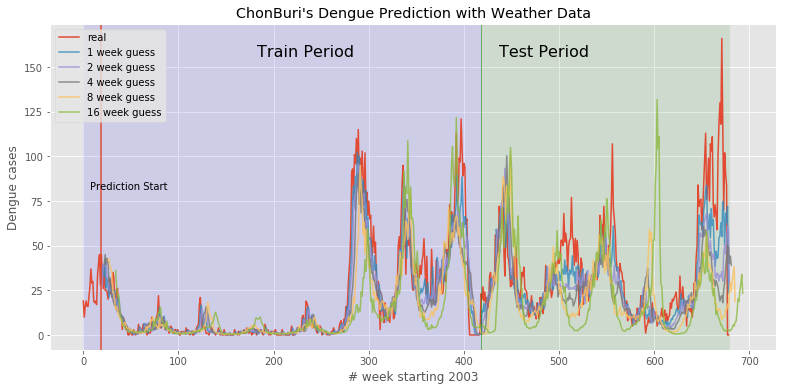

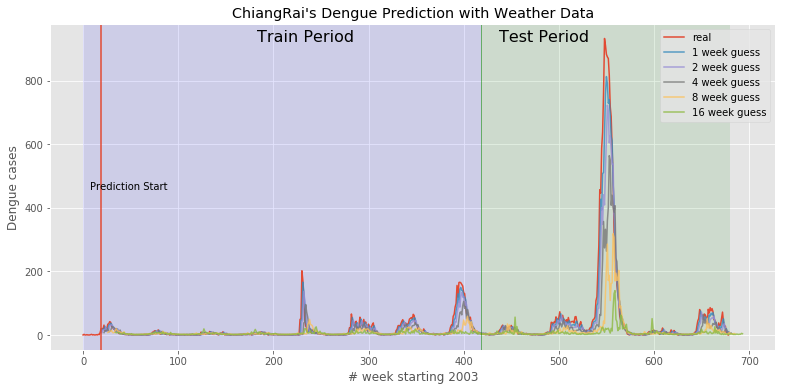

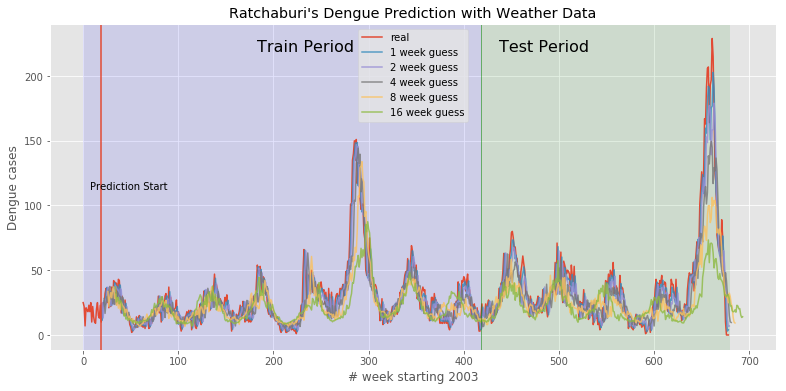

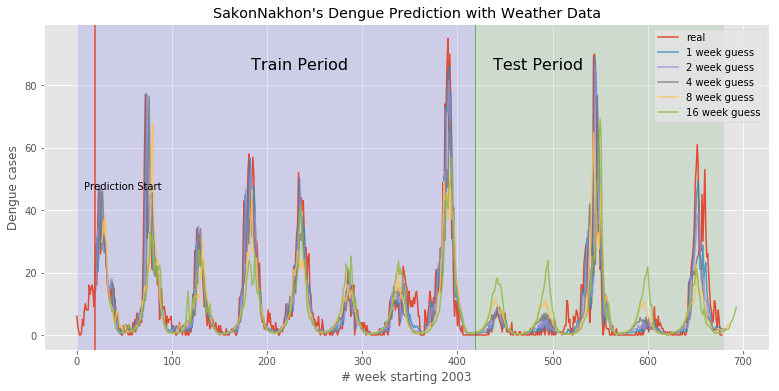

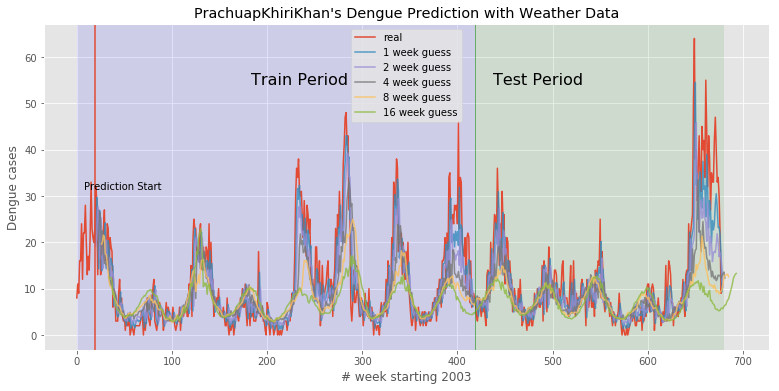

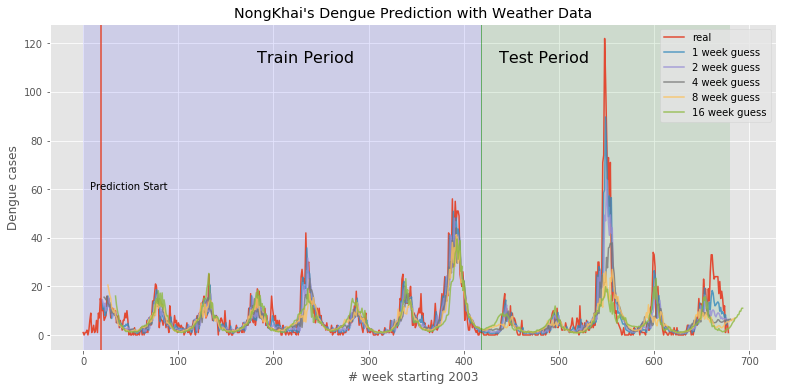

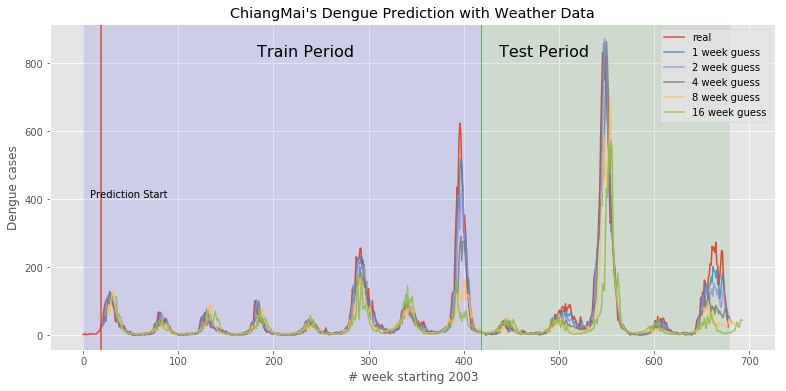

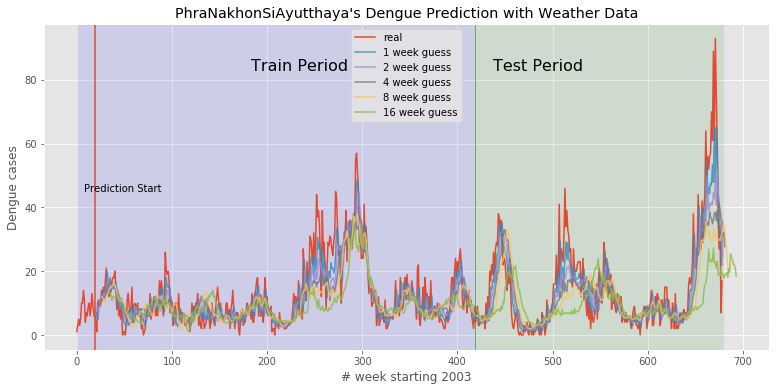

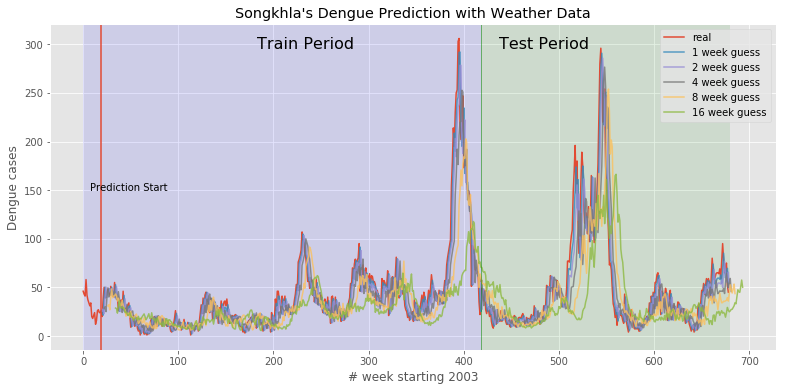

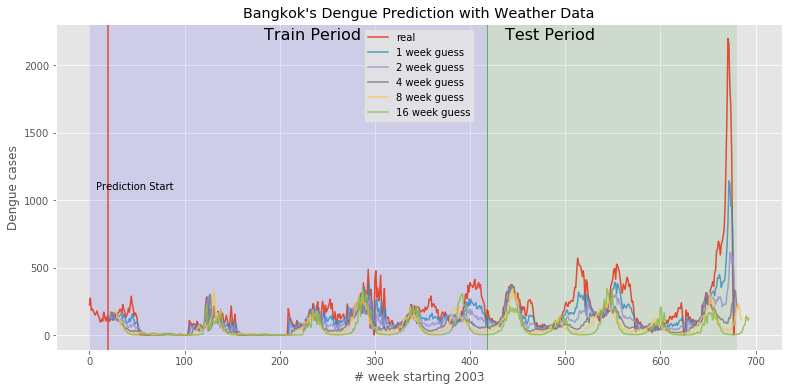

In [40]:
for idx in range(len(result_list)):
    cur_province = result_list[idx][0]
    cur_train = province_data[cur_province][0]
    cur_real = province_data[cur_province][1]
    cur_ws = result_list[idx][3]
    show_predictions(
                    [19,9,15,1],
                    cur_real,
                    cur_train,
                    cur_province,
                    cur_ws)

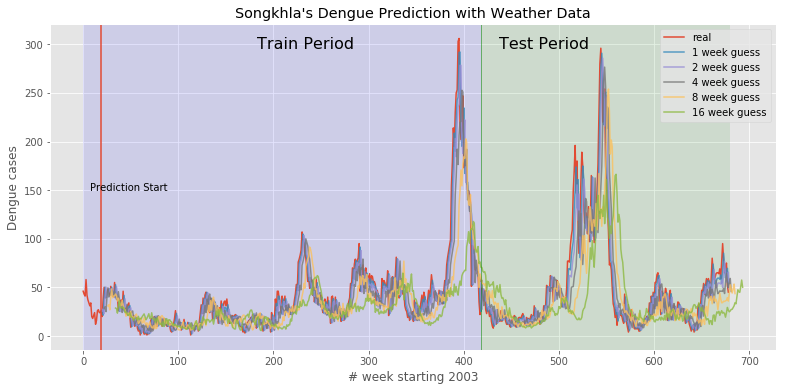

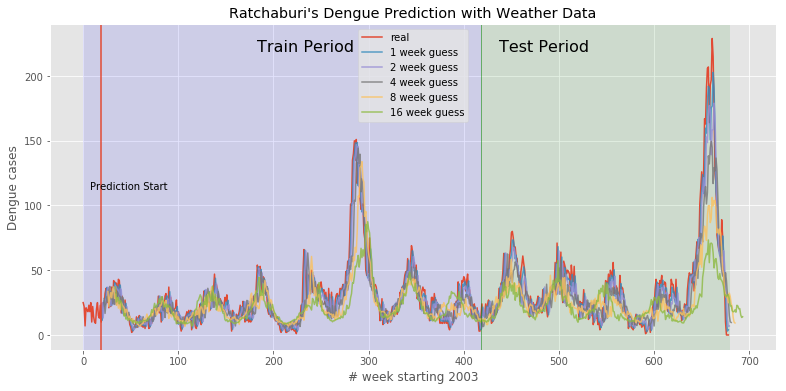

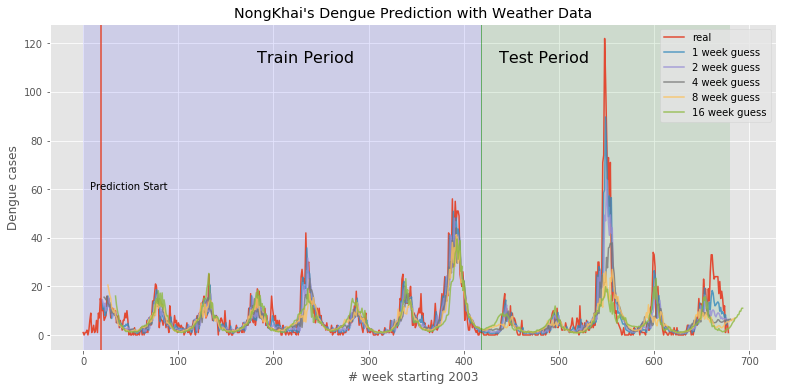

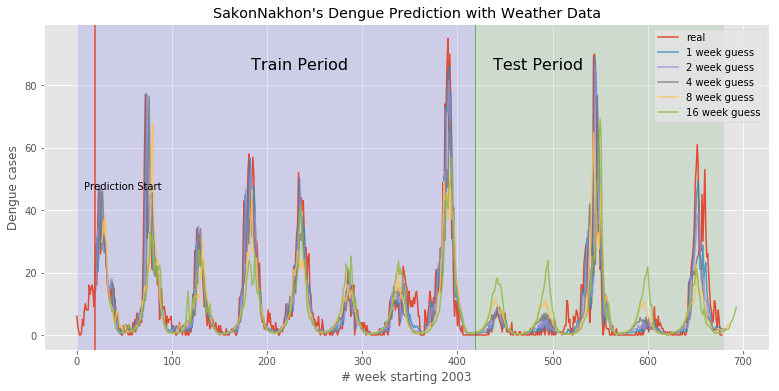

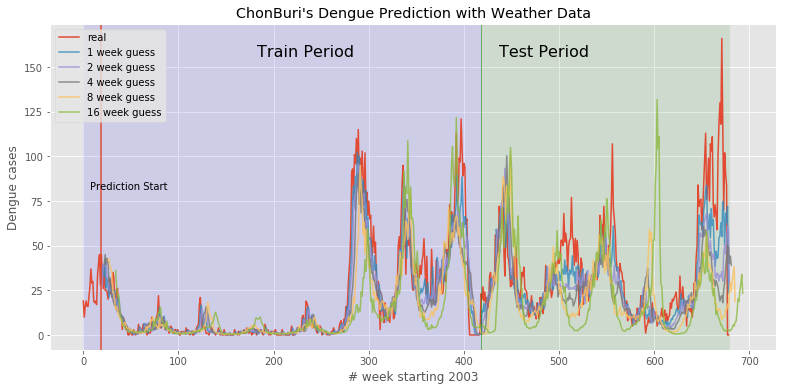

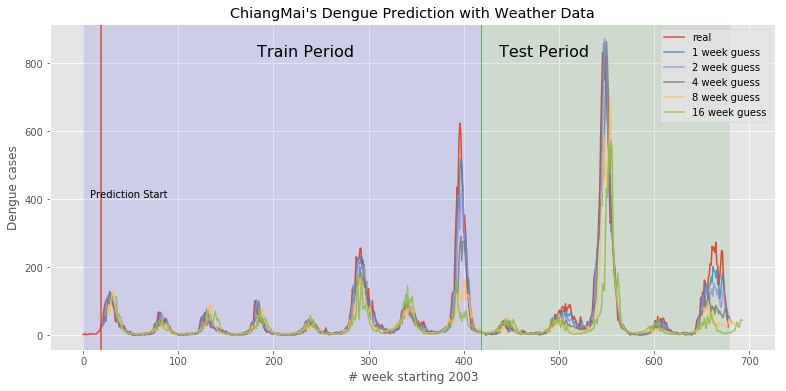

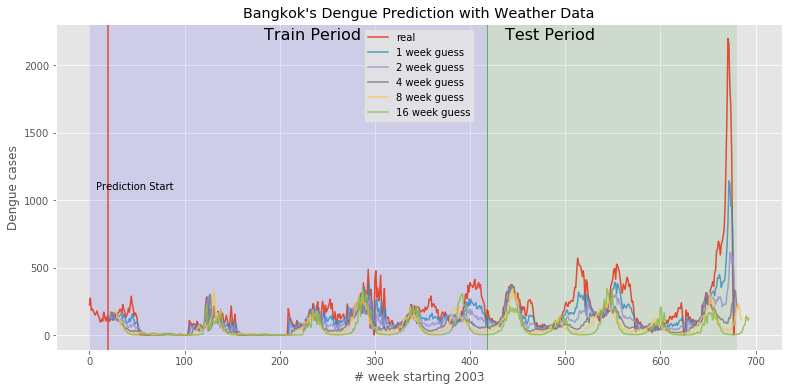

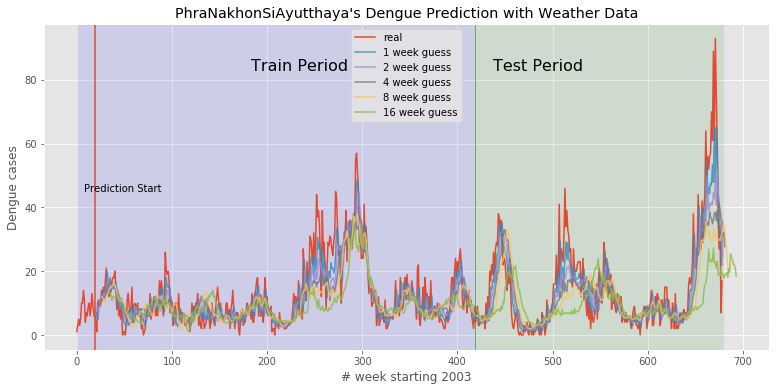

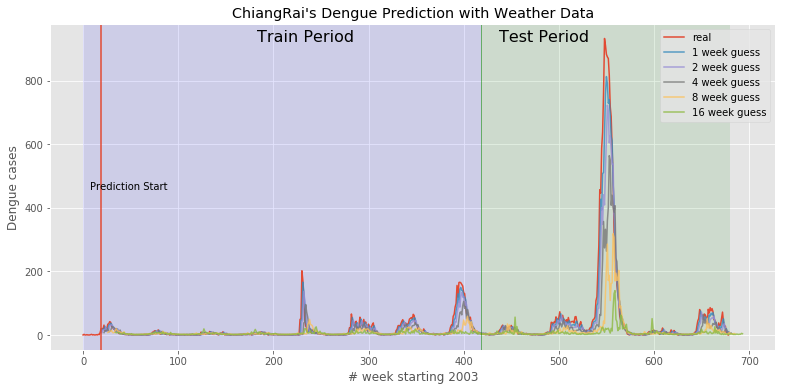

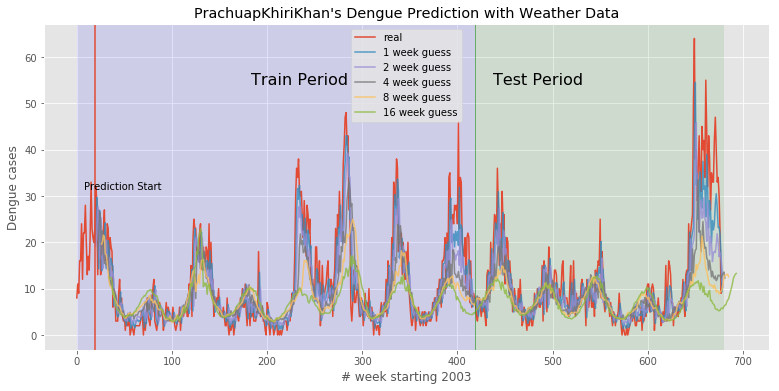

In [60]:
chosen_ws = glob.glob("province-ws-*.csv")
for ws_set_file in chosen_ws:
    raw_cur_ws = pd.read_csv(ws_set_file).T
    cur_ws = np.array(raw_cur_ws)[0]
    cur_province = ws_set_file[16:-4]
    cur_train = province_data[cur_province][0]
    cur_real = province_data[cur_province][1]
    show_predictions(
                    [19,9,15,1],
                    cur_real,
                    cur_train,
                    cur_province,
                    cur_ws)